In [146]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-classification/train (2).csv
/kaggle/input/fake-news-classification/evaluation.csv
/kaggle/input/fake-news-classification/test (1).csv
/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv
/kaggle/input/drug-dataset/Medicine_Details.csv
/kaggle/input/student-sleep-patterns/student_sleep_patterns.csv
/kaggle/input/credit-score-classification-cleaned-dataset/credit_score_cleaned_train.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv
/kaggle/input/mushroom-classification/mushrooms.csv
/kaggle/input/mountains-vs-beaches-preference/mountains_vs_beaches_preferences.csv
/kaggle/input/data-science-salaries-2023/ds_salaries.csv
/kaggle/input/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv
/kaggle/input/loan-approval-classification-data/loan_data.cs

KeyboardInterrupt: 

# Compare three models for any dataset

## Functions and imports

In [3]:
%pip install cma
import cma
import optuna
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 7.6 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [141]:
def preprocessing(dataset_file, target, test_size, val_size, categorical_features, sep):
    dataset = pd.read_csv(dataset_file, sep=sep)
    y = dataset[target]
    x = dataset.drop(columns=[target])
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    for cat_col in categorical_features:
        x[cat_col] = x[cat_col].astype('category').cat.codes

    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=(test_size+val_size), random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    print("Training set shape:", x_train.shape)
    print("Validation set shape:", x_val.shape)
    print("Testing set shape:", x_test.shape)

    train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
    val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    return train_data, val_data, test_data

In [110]:
def evaluate_model(model, test_data, is_binary=False):
    y_pred = model.predict(test_data.data, num_iteration=model.best_iteration)
        
    if is_binary:
        y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
    else:
        y_pred_class = y_pred.argmax(axis=1)

    accuracy = accuracy_score(test_data.label, y_pred_class)
    precision = precision_score(test_data.label, y_pred_class, average='weighted')
    recall = recall_score(test_data.label, y_pred_class, average='weighted')
    f1 = f1_score(test_data.label, y_pred_class, average='weighted')
    conf_matrix = confusion_matrix(test_data.label, y_pred_class)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1: {f1 * 100:.2f}%")
    
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [80]:
def benchmark_model(train_data, val_data, test_data, is_binary):
    params = {
    'objective': 'binary'if is_binary else 'multiclass',
    'metric': 'binary_logloss' if is_binary else 'multi_logloss',
    'num_class': None if is_binary else len(set(train_data.get_label())),
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
    }

    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)
    
    print("\n-------------------------------------------------------------\n")
    print("Benchmark model\n")
    evaluate_model(lgb_model, test_data, is_binary)

In [99]:
def optuna_model(train_data, val_data, test_data, is_binary):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def objective(trial):
        params = {
            'objective': 'binary'if is_binary else 'multiclass',
            'metric': 'binary_logloss' if is_binary else 'multi_logloss',
            'num_class': None if is_binary else len(set(train_data.get_label())),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int("num_leaves", 20, 150),
            # 'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
            'feature_fraction': trial.suggest_float("feature_fraction", 0.5, 0.9),
            'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.9),
            'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
            'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            'verbose': -1
        }
    
        lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)
    
        y_pred = lgb_model.predict(test_data.data, num_iteration=lgb_model.best_iteration)
        if is_binary:
            y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
        else:
            y_pred_class = y_pred.argmax(axis=1)
        
        accuracy = accuracy_score(test_data.label, y_pred_class)
    
        return accuracy

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    
    trial = study.best_trial

    print("\n-------------------------------------------------------------\n")
    print("Optuna\n")
    print("Accuracy: {}".format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))

    best_params = {
        'objective': 'binary'if is_binary else 'multiclass',
        'metric': 'binary_logloss' if is_binary else 'multi_logloss',
        'num_class': None if is_binary else len(set(train_data.get_label())),
        'learning_rate': study.best_trial.params['learning_rate'],
        'num_leaves': study.best_trial.params['num_leaves'],
        # 'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
        'feature_fraction': study.best_trial.params['feature_fraction'],
        'bagging_fraction': study.best_trial.params['bagging_fraction'],
        'bagging_freq': study.best_trial.params['bagging_freq'],
        'lambda_l1': study.best_trial.params['lambda_l1'],
        'lambda_l2': study.best_trial.params['lambda_l2'],
        'verbose': -1
    }
    lgb_model_best = lgb.train(best_params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

    evaluate_model(lgb_model_best, test_data, is_binary)

In [104]:
def cmaes_model(train_data, val_data, test_data, is_binary):
    def objective(params):
        learning_rate, num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, lambda_l1, lambda_l2 = params
    
        lgb_params = {
            'objective': 'binary'if is_binary else 'multiclass',
            'metric': 'binary_logloss' if is_binary else 'multi_logloss',
            'num_class': None if is_binary else len(set(train_data.get_label())),
            'learning_rate': learning_rate,
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf),
            'feature_fraction': feature_fraction,
            'bagging_fraction': bagging_fraction,
            'bagging_freq': int(bagging_freq),
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'verbose': -1
        }
    
        lgb_model = lgb.train(lgb_params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)
        
        y_pred = lgb_model.predict(test_data.data, num_iteration=lgb_model.best_iteration)
        if is_binary:
            y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
        else:
            y_pred_class = y_pred.argmax(axis=1)
        
        accuracy = accuracy_score(test_data.label, y_pred_class)
    
        return -accuracy

    bounds = [[0.01, 20, 20, 0.5, 0.5, 1, 1e-8, 1e-8], [0.3, 150, 100, 0.9, 0.9, 10, 10.0, 10.0]]
    initial_params = [0.1, 31, 20, 0.8, 0.8, 5, 1e-5, 1e-5]
    
    result = cma.fmin(objective, initial_params, 0.5, {'bounds': bounds, 'verbose': -9})

    print("\n-------------------------------------------------------------\n")
    print("CMA-ES\n")
    print(f"Accuracy {-result[1]}")
    print("Best hyperparameters: {}".format(result[0]))

    best_params = result[0]
    lgb_params = {
        'objective': 'binary'if is_binary else 'multiclass',
        'metric': 'binary_logloss' if is_binary else 'multi_logloss',
        'num_class': None if is_binary else len(set(train_data.get_label())),
        'learning_rate': best_params[0],
        'num_leaves': int(best_params[1]),
        'min_data_in_leaf': int(best_params[2]),
        'feature_fraction': best_params[3],
        'bagging_fraction': best_params[4],
        'bagging_freq': int(best_params[5]),
        'lambda_l1': best_params[6],
        'lambda_l2': best_params[7],
        'verbose': -1
    }
    lgb_model_best = lgb.train(lgb_params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

    evaluate_model(lgb_model_best, test_data, is_binary)

In [142]:
def compare_models(data_file, target_col, cat_features, sep=','):
    train_data, val_data, test_data = preprocessing(data_file, target_col, 0.1, 0.1, cat_features, sep)
    if len(set(train_data.get_label())) == 2:
        is_binary = True
    else:
        is_binary = False
        
    benchmark_model(train_data, val_data, test_data, is_binary)
    optuna_model(train_data, val_data, test_data, is_binary)
    cmaes_model(train_data, val_data, test_data, is_binary)

## Mushrooms

Training set shape: (6499, 22)
Validation set shape: (812, 22)
Testing set shape: (813, 22)

-------------------------------------------------------------

Benchmark model

Accuracy: 99.51%
Precision: 99.51%
Recall: 99.51%
F1: 99.51%


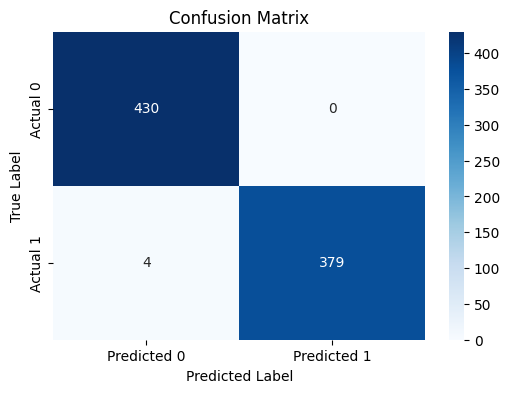


-------------------------------------------------------------

Optuna

Accuracy: 1.0
Best hyperparameters: {'learning_rate': 0.240828187594218, 'num_leaves': 42, 'feature_fraction': 0.6877361841380052, 'bagging_fraction': 0.6914338676707306, 'bagging_freq': 5, 'lambda_l1': 0.000751935739192517, 'lambda_l2': 3.8690973447530493e-05}
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


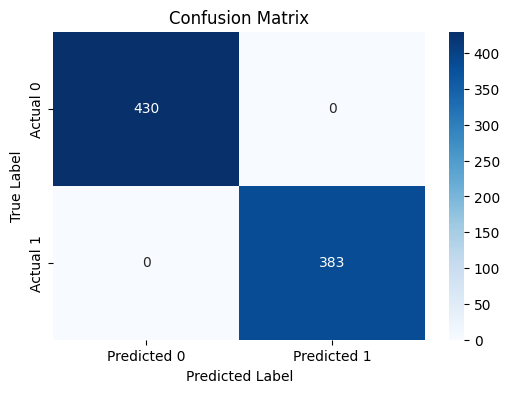


-------------------------------------------------------------

CMA-ES

Accuracy 1.0
Best hyperparameters: [ 0.29999807 30.84095308 20.01973104  0.6828595   0.75209584  5.78774977
  0.5378385   0.32726493]
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


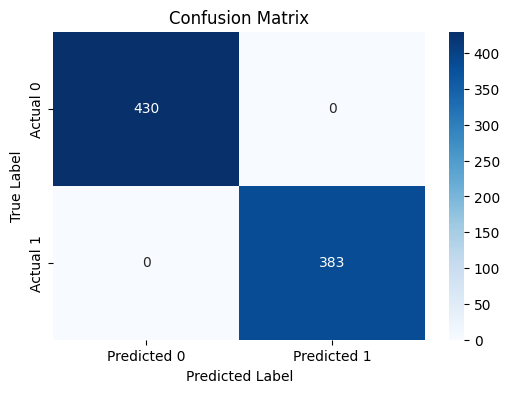

In [106]:
categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']

compare_models("/kaggle/input/mushroom-classification/mushrooms.csv", "class", categorical_features)

## Heart attack prediction

Training set shape: (242, 13)
Validation set shape: (30, 13)
Testing set shape: (31, 13)

-------------------------------------------------------------

Benchmark model

Accuracy: 87.10%
Precision: 87.98%
Recall: 87.10%
F1: 87.18%


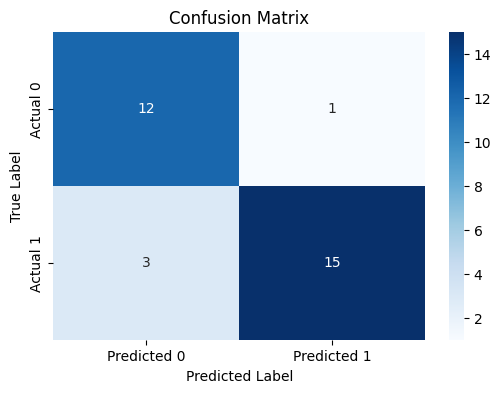


-------------------------------------------------------------

Optuna

Accuracy: 0.9032258064516129
Best hyperparameters: {'learning_rate': 0.029986274587747618, 'num_leaves': 122, 'feature_fraction': 0.7244308776113415, 'bagging_fraction': 0.8782147839700477, 'bagging_freq': 8, 'lambda_l1': 8.434414371586957e-05, 'lambda_l2': 0.12266868503665106}
Accuracy: 90.32%
Precision: 90.59%
Recall: 90.32%
F1: 90.36%


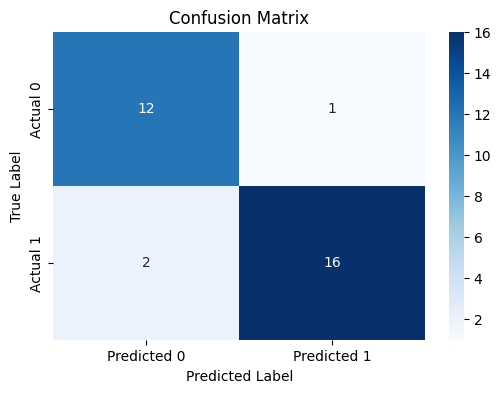


-------------------------------------------------------------

CMA-ES

Accuracy 0.9032258064516129
Best hyperparameters: [ 0.04137649 31.21951158 20.29499825  0.67086198  0.50068081  5.75951317
  0.17785665  0.32512009]
Accuracy: 90.32%
Precision: 90.39%
Recall: 90.32%
F1: 90.26%


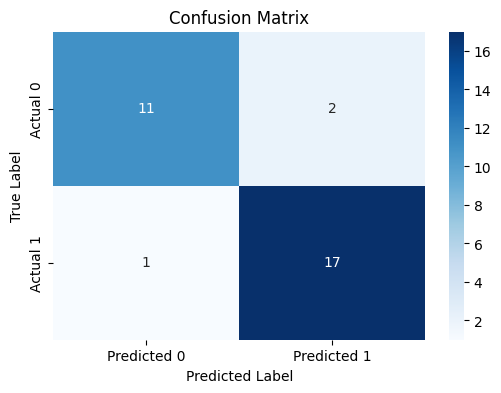

In [107]:
categorical_features = []

compare_models("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv", "output", categorical_features)

## Mobile device usage and user behavior

Training set shape: (560, 10)
Validation set shape: (70, 10)
Testing set shape: (70, 10)

-------------------------------------------------------------

Benchmark model

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


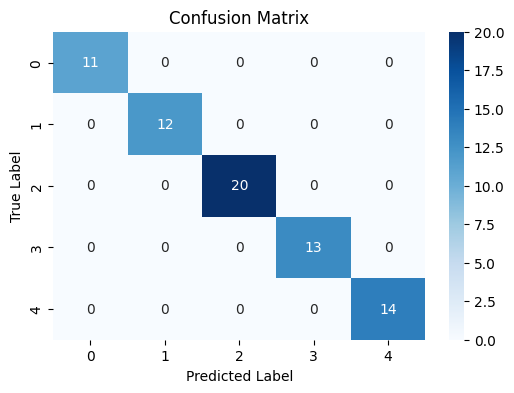


-------------------------------------------------------------

Optuna

Accuracy: 1.0
Best hyperparameters: {'learning_rate': 0.2368139551721583, 'num_leaves': 54, 'feature_fraction': 0.5304418807163147, 'bagging_fraction': 0.8053537198608589, 'bagging_freq': 4, 'lambda_l1': 0.02428138793950641, 'lambda_l2': 0.00827672809485422}
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


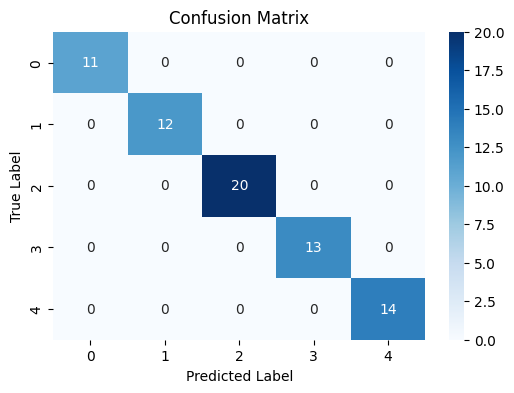


-------------------------------------------------------------

CMA-ES

Accuracy 1.0
Best hyperparameters: [2.75468217e-02 3.06262726e+01 2.00021744e+01 5.28189864e-01
 8.66633510e-01 5.55717966e+00 7.07791840e-03 4.71676413e-01]
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


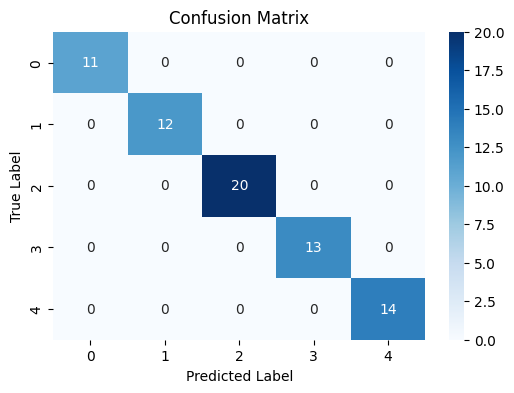

In [111]:
categorical_features = ['Device Model', 'Operating System', 'Gender']

compare_models("/kaggle/input/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv", "User Behavior Class", categorical_features)

## Mobile price classification

Training set shape: (1600, 20)
Validation set shape: (200, 20)
Testing set shape: (200, 20)

-------------------------------------------------------------

Benchmark model

Accuracy: 86.50%
Precision: 88.00%
Recall: 86.50%
F1: 86.64%


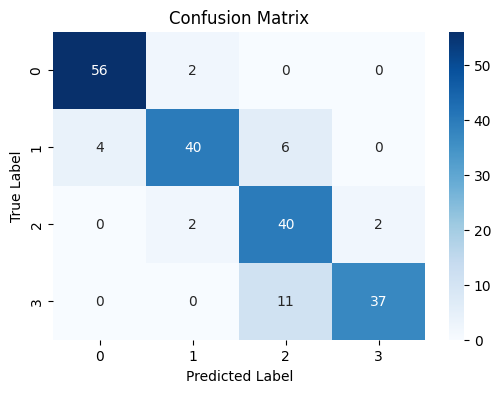


-------------------------------------------------------------

Optuna

Accuracy: 0.94
Best hyperparameters: {'learning_rate': 0.22981041502666683, 'num_leaves': 138, 'feature_fraction': 0.8865764226417165, 'bagging_fraction': 0.8391431784783949, 'bagging_freq': 5, 'lambda_l1': 0.001344059749726332, 'lambda_l2': 2.3509128378217215e-08}
Accuracy: 94.00%
Precision: 94.47%
Recall: 94.00%
F1: 94.04%


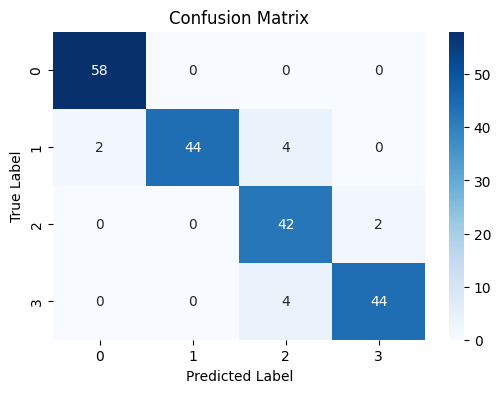


-------------------------------------------------------------

CMA-ES

Accuracy 0.955
Best hyperparameters: [2.80476440e-01 3.25655916e+01 2.00426512e+01 8.93556591e-01
 8.08109064e-01 5.53663564e+00 1.54413013e-01 1.30925285e-03]
Accuracy: 95.50%
Precision: 95.48%
Recall: 95.50%
F1: 95.48%


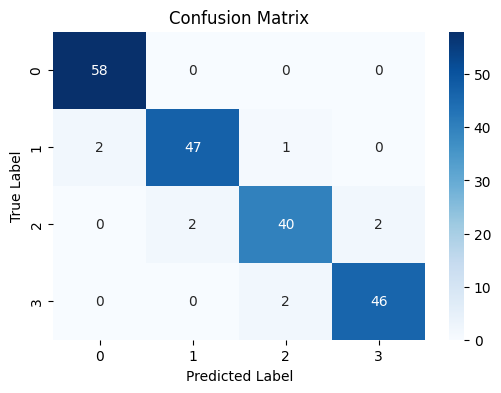

In [155]:
categorical_features = []

compare_models("/kaggle/input/mobile-price-classification/train.csv", "price_range", categorical_features)

## Loan approval classification

Training set shape: (36000, 13)
Validation set shape: (4500, 13)
Testing set shape: (4500, 13)

-------------------------------------------------------------

Benchmark model

Accuracy: 86.40%
Precision: 88.25%
Recall: 86.40%
F1: 83.97%


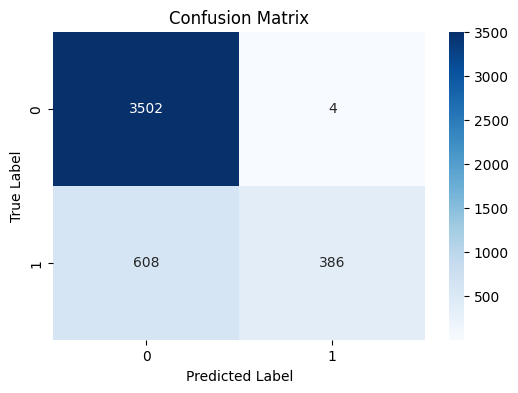


-------------------------------------------------------------

Optuna

Accuracy: 0.9293333333333333
Best hyperparameters: {'learning_rate': 0.2648692360118983, 'num_leaves': 123, 'feature_fraction': 0.6329267766998147, 'bagging_fraction': 0.8397179086141812, 'bagging_freq': 1, 'lambda_l1': 6.615909795887289e-08, 'lambda_l2': 1.2327372732966433e-06}
Accuracy: 92.93%
Precision: 92.81%
Recall: 92.93%
F1: 92.72%


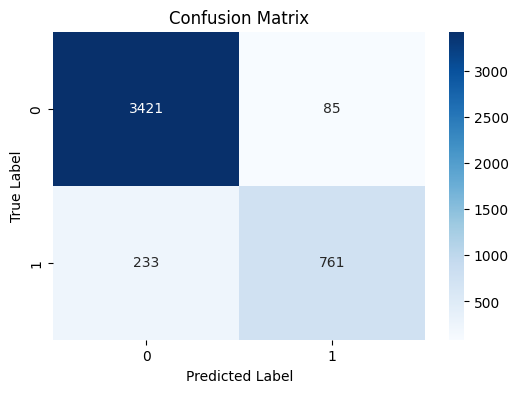


-------------------------------------------------------------

CMA-ES

Accuracy 0.928
Best hyperparameters: [ 0.29775711 32.45779211 21.62022305  0.51910304  0.89997929  7.61303122
  1.02992501  0.29254124]
Accuracy: 92.80%
Precision: 92.79%
Recall: 92.80%
F1: 92.48%


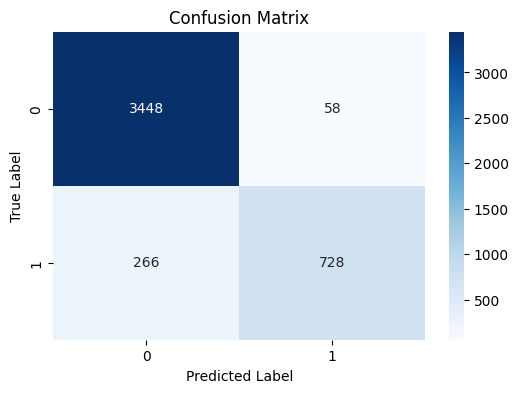

In [127]:
categorical_features = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

compare_models("/kaggle/input/loan-approval-classification-data/loan_data.csv", "loan_status", categorical_features)

## Beaches vs mountains preference

Training set shape: (41955, 13)
Validation set shape: (5244, 13)
Testing set shape: (5245, 13)

-------------------------------------------------------------

Benchmark model

Accuracy: 96.45%
Precision: 96.61%
Recall: 96.45%
F1: 96.36%


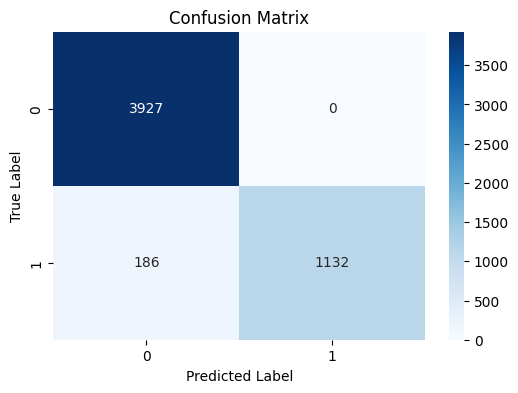


-------------------------------------------------------------

Optuna

Accuracy: 0.9977121067683508
Best hyperparameters: {'learning_rate': 0.29590766566735477, 'num_leaves': 49, 'feature_fraction': 0.7019914265304831, 'bagging_fraction': 0.7361319381024923, 'bagging_freq': 2, 'lambda_l1': 0.749328297065283, 'lambda_l2': 0.00011457676398988897}
Accuracy: 99.77%
Precision: 99.77%
Recall: 99.77%
F1: 99.77%


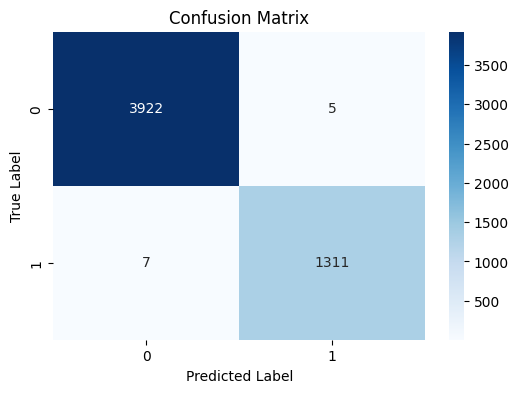


-------------------------------------------------------------

CMA-ES

Accuracy 0.9988560533841754
Best hyperparameters: [ 0.29994637 30.10937255 20.26585246  0.8967504   0.5132613   4.05398105
  0.23937708  0.35398352]
Accuracy: 99.89%
Precision: 99.89%
Recall: 99.89%
F1: 99.89%


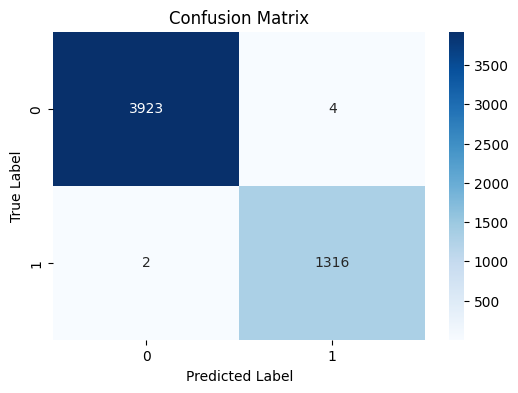

In [153]:
categorical_features = ['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season']

compare_models("/kaggle/input/mountains-vs-beaches-preference/mountains_vs_beaches_preferences.csv", "Preference", categorical_features)

# First lightgbm model
Mostly to check which parameters we want to use for training

In [ ]:
dataset = pd.read_csv("/kaggle/input/mushroom-classification/mushrooms.csv")
dataset.head()

In [ ]:
y = dataset['class']
x = dataset.drop(columns=['class'])
x.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
np.bincount(y)

In [ ]:
for cat_col in x.columns:
    x[cat_col] = x[cat_col].astype('category').cat.codes

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Testing set shape:", x_test.shape)

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']

train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
lgb.plot_importance(lgb_model, importance_type='split')
plt.show()

# Training with optuna

In [ ]:
import optuna

def objective(trial):

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 150),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.5, 0.9),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.9),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
        'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'verbose': -1
    }

    categorical_features = ['cap-surface', 'bruises', 'odor','gill-attachment', 
                            'gill-spacing', 'gill-size','stalk-surface-above-ring', 
                            'veil-color', 'ring-number', 'spore-print-color']

    train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

    y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

    accuracy = accuracy_score(y_test, y_pred_class)

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
best_params = study.best_trial.params
lgb_model_best = lgb.LGBMClassifier(**best_params)

lgb_model_best.fit(x_train, y_train)

y_pred = lgb_model_best.predict(x_test)
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

# Training with CMA-ES

In [ ]:
%pip install cmaes

In [ ]:
import cma

categorical_features = ['cap-surface', 'bruises', 'odor', 'gill-attachment', 
                        'gill-spacing', 'gill-size', 'stalk-surface-above-ring', 
                        'veil-color', 'ring-number', 'spore-print-color']

def objective(params):
    learning_rate, num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, lambda_l1, lambda_l2 = params

    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'min_data_in_leaf': int(min_data_in_leaf),
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'verbose': -1
    }

    train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    lgb_model = lgb.train(lgb_params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

    y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

    accuracy = accuracy_score(y_test, y_pred_class)

    return -accuracy

lower_bounds = [0.01, 20, 20, 0.5, 0.5, 1, 1e-8, 1e-8]
upper_bounds = [0.3, 150, 100, 0.9, 0.9, 10, 10.0, 10.0]
bounds = [lower_bounds, upper_bounds]

initial_params = [0.1, 31, 20, 0.8, 0.8, 5, 1e-5, 1e-5]

result = cma.fmin(objective, initial_params, 0.5, {'bounds': bounds})

print("Best parameters found by CMA-ES:")
print(result[0])
print("Objective function value (negative accuracy):", result[1])


In [ ]:
best_params = result[0]
lgb_model_best = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    learning_rate=best_params[0],
    num_leaves=int(best_params[1]),
    min_data_in_leaf=int(best_params[2]),
    feature_fraction=best_params[3],
    bagging_fraction=best_params[4],
    bagging_freq=int(best_params[5]),
    lambda_l1=best_params[6],
    lambda_l2=best_params[7],
    verbose=-1
)

lgb_model_best.fit(x_train, y_train)

y_pred = lgb_model_best.predict(x_test)
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()